# 目的
追加データとして使えるか判断する
- B-NAME_STUDENTなどと同じ項目が存在するか、データ量はどの程度か。

In [29]:
import json
import polars as pl
import ast
import matplotlib.pyplot as plt

In [11]:
# Read JSONL file
with open("../data/english_pii_43k.jsonl", "r") as f:
    data = [json.loads(line) for line in f]

# Convert to Polars DataFrame
df = pl.DataFrame(data)

In [12]:
df

masked_text,unmasked_text,privacy_mask,span_labels,bio_labels,tokenised_text
str,str,str,str,list[str],list[str]
"""A student's as…","""A student's as…","""{'[PHONEIMEI_1…","""[[0, 57, 'O'],…","[""O"", ""O"", … ""O""]","[""a"", ""student"", … ""?""]"
"""Dear [FIRSTNAM…","""Dear Omer, as …","""{'[FIRSTNAME_1…","""[[0, 5, 'O'], …","[""O"", ""B-FIRSTNAME"", … ""O""]","[""dear"", ""om"", … "".""]"
"""[FIRSTNAME_1] …","""Kattie could y…","""{'[FIRSTNAME_1…","""[[0, 6, 'FIRST…","[""B-FIRSTNAME"", ""I-FIRSTNAME"", … ""O""]","[""kat"", ""##tie"", … ""?""]"
"""Emergency supp…","""Emergency supp…","""{'[BUILDINGNUM…","""[[0, 22, 'O'],…","[""O"", ""O"", … ""O""]","[""emergency"", ""supplies"", … "".""]"
"""The [AGE_1] ol…","""The 88 old chi…","""{'[AGE_1]': '8…","""[[0, 4, 'O'], …","[""O"", ""B-AGE"", … ""O""]","[""the"", ""88"", … "".""]"
"""Your recent ho…","""Your recent ho…","""{'[DOB_1]': '2…","""[[0, 38, 'O'],…","[""O"", ""O"", … ""O""]","[""your"", ""recent"", … "".""]"
"""Dear [GENDER_1…","""Dear Trans mal…","""{'[GENDER_1]':…","""[[0, 5, 'O'], …","[""O"", ""B-GENDER"", … ""O""]","[""dear"", ""trans"", … "".""]"
"""The wellness p…","""The wellness p…","""{'[NEARBYGPSCO…","""[[0, 37, 'O'],…","[""O"", ""O"", … ""O""]","[""the"", ""wellness"", … "".""]"
"""[FIRSTNAME_1],…","""Carleton, the …","""{'[FIRSTNAME_1…","""[[0, 8, 'FIRST…","[""B-FIRSTNAME"", ""O"", … ""O""]","[""carleton"", "","", … "".""]"


In [43]:
idx = 13
for label, token in zip(df["bio_labels"][idx], df["tokenised_text"][idx]):
    print(label, token)

B-PREFIX ms
I-PREFIX .
O north
O ,
O our
O office
O in
B-COUNTY essex
O confirmed
O your
O visit
O with
O health
O psychologist
O at
B-TIME 10
I-TIME :
I-TIME 02
I-TIME am
O .
O your
O file
O with
O id
B-PHONEIMEI 04
I-PHONEIMEI -
I-PHONEIMEI 55
I-PHONEIMEI ##86
I-PHONEIMEI ##19
I-PHONEIMEI -
I-PHONEIMEI 83
I-PHONEIMEI ##26
I-PHONEIMEI ##0
I-PHONEIMEI ##4
I-PHONEIMEI -
I-PHONEIMEI 8
O is
O updated
O .


In [33]:
df["unmasked_text"][0]

"A student's assessment was found on device bearing IMEI: 06-184755-866851-3. The document falls under the various topics discussed in our Optimization curriculum. Can you please collect it?"

Text(0, 0.5, 'Frequency')

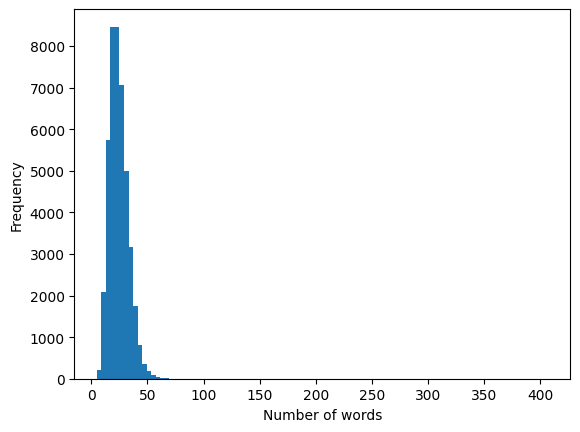

In [32]:
plt.hist(df["unmasked_text"].map_elements(lambda x: len(x.split())).to_list(), bins=100)
plt.xlabel("Number of words")
plt.ylabel("Frequency")
# 一文が短い？

In [ ]:
# tagの変更案
# B-FIRSTNAME > B-NAME_STUDENT
# B-FIRSTNAME, I-FIRSTNAME > 結合して、B-NAME_STUDENT
# B-LASTNAME > I-NAME_STUDENT
# B-LASTNAME, I-LASTNAME > 結合して、I-NAME_STUDENT

# B-STREET > B-STREET_ADDRESS
# I-STREET > I-STREET_ADDRESS
#